# Install and import

In [2]:
!pip install wordcloud
!pip install seaborn
!pip install spacy
!pip install wordcloud

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 1.6 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=16eec43e385b1f31d9e0738f4c4e8d3fa430d669ccccf8bac75ee34f1c672068
  Stored in directory: /tmp/pip-ephem-wheel-cache-_nh1ievx/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/venv/lib/python3.7/site-packages/en_core_web_sm -->
/opt/venv/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
import pandas as pd
import csv
import numpy as np
import time
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Load and process data

In [5]:
data = pd.read_csv('ug_processed.csv')

In [9]:
qualitative_data = data.loc[:,['level', 'preferred_mode','why_mode', 'preference', 'why_preference', 'remote_changes', 'prior_changes']]
qualitative_data.head()

,level,preferred_mode,why_mode,preference,why_preference,remote_changes,prior_changes
0,Undergraduate (studying for associates or bach...,recorded,Easier to follow and look back on,In-person Courses,Easier to debate,More live debate,NaN
1,Undergraduate (studying for associates or bach...,live,Most similar to normality and provides a routine,In-person Courses,It’s easier to learn and ask questions,Not sure,NaN
2,Undergraduate (studying for associates or bach...,live,It is more interactive,In-person Courses,I find them more engaging,I would make them more interactive,NaN
3,Undergraduate (studying for associates or bach...,live,Allows more of a conversation to flow and ques...,Online Courses,Gives more freedom,More group activities within the class time to...,Number of fun/group activities
4,Undergraduate (studying for associates or bach...,live,NaN,In-person Courses,I simply enjoy the university life,The classes should be as regular as during a n...,NaN


# Build the model

In [7]:
# sentence tokenization
nlp = spacy.load('en')
def tokenize(text):
  ls = []
  if not pd.isna(text):
    tokens = nlp(text)
    for token in tokens:
      if not token.is_stop and not token.is_punct:
        ls.append(str(token.lemma_).lower())
  return ls

tokenize('I am loving a very nice talk.')

['love', 'nice', 'talk']

In [8]:
# build word cloud 
def word_cloud(data, col):
  start = time.time()
  token = data[col].apply(tokenize)
  token_string = []
  for idx, row in token.iteritems():
    token_string.extend(row)
  freq = pd.Series(token_string).rename('token_freq').value_counts(normalize=True)
  token_string = ' '.join(token_string)
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_string)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show()
  end = time.time()
  return end-start, freq

# Run the model

## Why someone prefers in person or remote learning

Why a student prefers In-person Courses


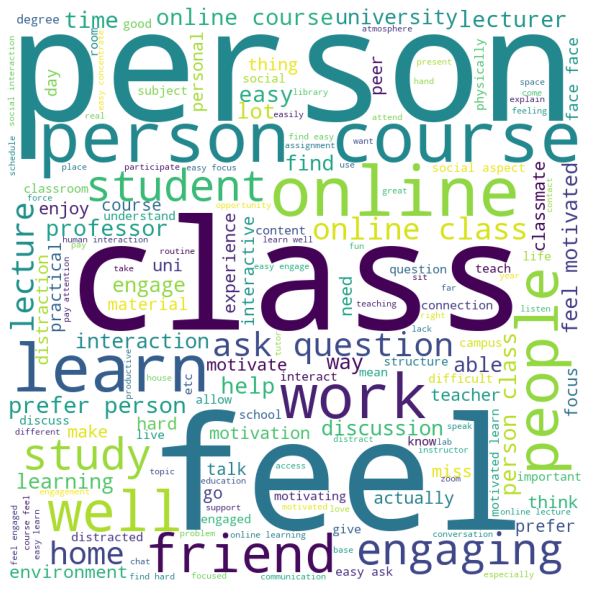

(63.33838653564453, person         0.038488
online         0.027031
feel           0.025219
class          0.025017
course         0.024324
                 ...   
59             0.000022
philippines    0.000022
obliged        0.000022
adaptable      0.000022
understand/    0.000022
Name: token_freq, Length: 3168, dtype: float64)
Why a student prefers Online Courses


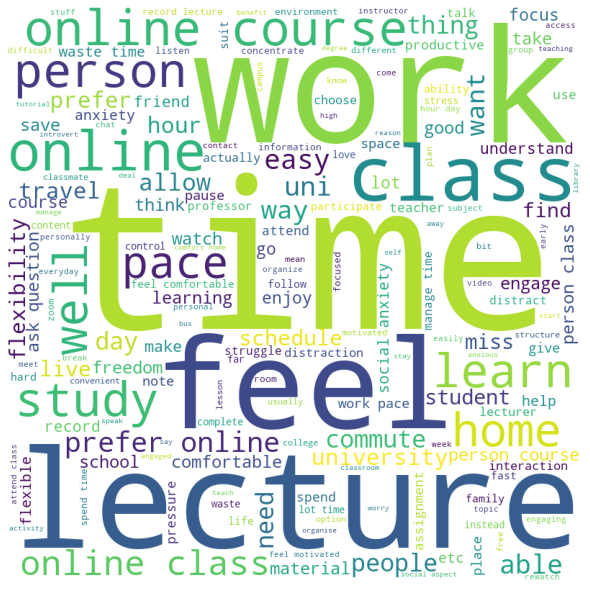

(12.0977623462677, time          0.042242
online        0.039454
class         0.026070
work          0.020633
person        0.018263
                ...   
message       0.000139
prepared      0.000139
preferably    0.000139
send          0.000139
smooth        0.000139
Name: token_freq, Length: 1324, dtype: float64)


In [11]:
for answer in qualitative_data['preference'].unique():
    print(f'Why a student prefers {answer}')
    print(word_cloud(qualitative_data[qualitative_data['preference']==answer], 'why_preference'))

## Why someone prefers a certain mode of learning

Why a student prefers recorded


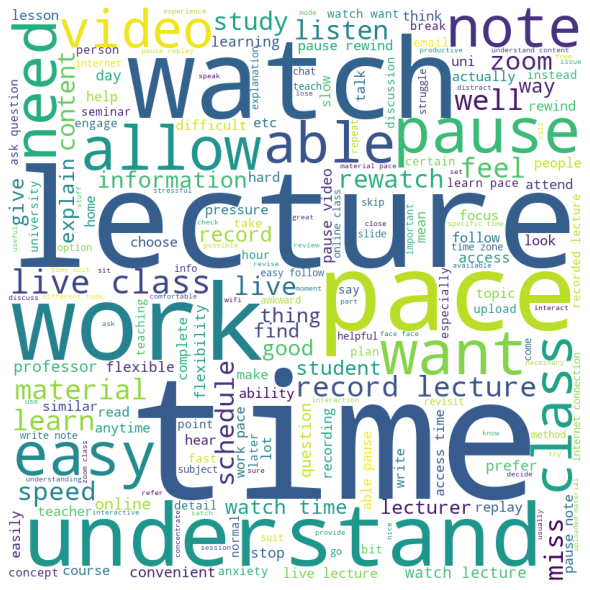

(22.455206871032715, time               0.050091
lecture            0.037331
pause              0.024571
watch              0.023709
class              0.019916
                     ...   
se                 0.000086
administrative     0.000086
downside           0.000086
procrastination    0.000086
accordingly        0.000086
Name: token_freq, Length: 1388, dtype: float64)
Why a student prefers live


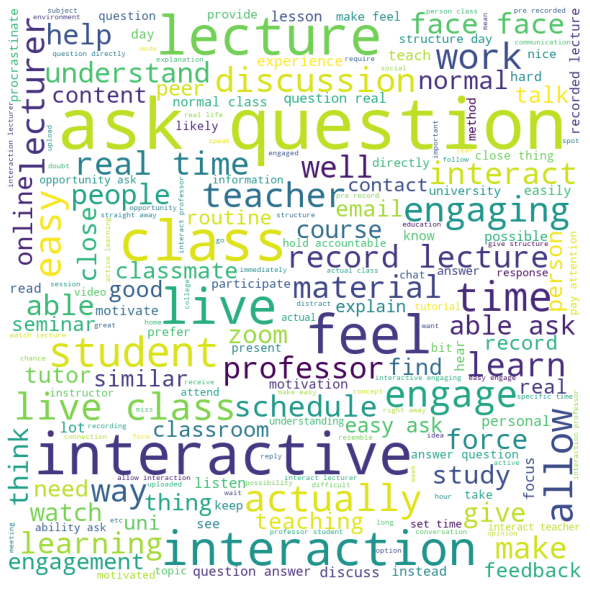

(30.9602792263031, question    0.039716
ask         0.036260
class       0.029954
lecture     0.024557
live        0.020859
              ...   
loud        0.000061
rewind      0.000061
check       0.000061
-helps      0.000061
et          0.000061
Name: token_freq, Length: 1516, dtype: float64)
Why a student prefers upload


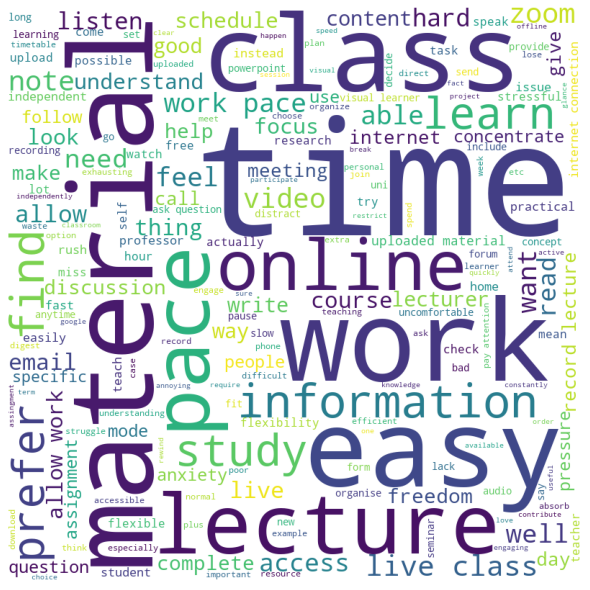

(5.589675664901733, time           0.043318
work           0.032719
class          0.026267
pace           0.023502
material       0.023502
                 ...   
clarity        0.000461
comfortable    0.000461
mixture        0.000461
actor          0.000461
barely         0.000461
Name: token_freq, Length: 627, dtype: float64)
Why a student prefers chat


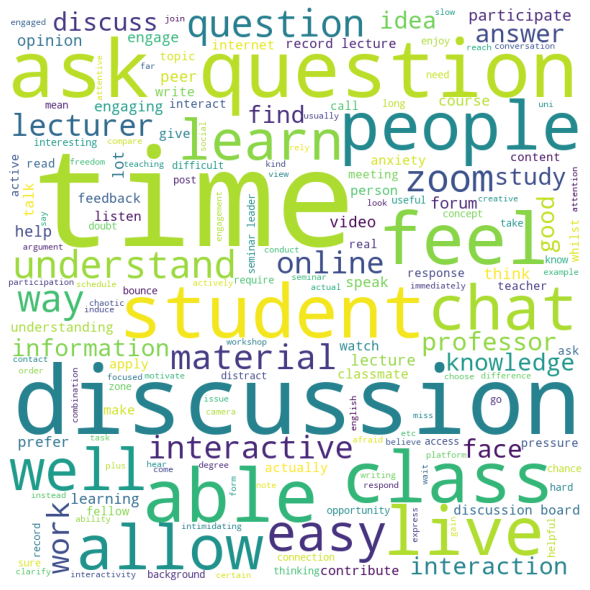

(3.733285427093506, question      0.026232
time          0.023847
discussion    0.022258
ask           0.019873
student       0.014308
                ...   
casual        0.000795
microsoft     0.000795
barrier       0.000795
r             0.000795
soak          0.000795
Name: token_freq, Length: 476, dtype: float64)


In [12]:
for answer in qualitative_data['preferred_mode'].unique():
    print(f'Why a student prefers {answer}')
    print(word_cloud(qualitative_data[qualitative_data['preferred_mode']==answer], 'why_mode'))

What changes students would make to current remote learning experiences


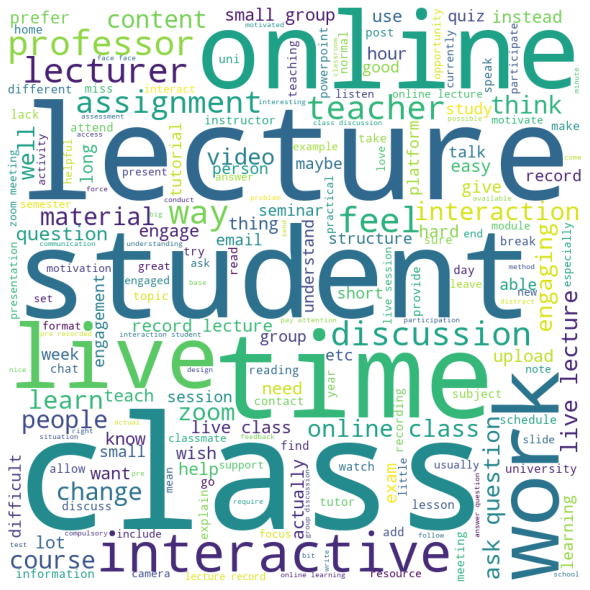

(64.96749114990234, class          0.032862
lecture        0.029410
live           0.022353
online         0.018296
like           0.015625
                 ...   
quizzes/       0.000025
sum            0.000025
necessitate    0.000025
modality       0.000025
interactio     0.000025
Name: token_freq, Length: 3230, dtype: float64)


In [14]:
print('What changes students would make to current remote learning experiences')
print(word_cloud(qualitative_data, 'remote_changes'))

What changes students would make to prior learning experiences


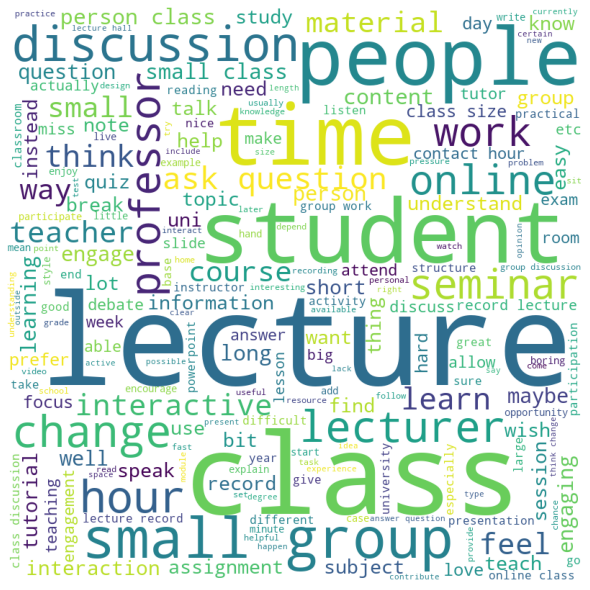

(42.55971002578735, class       0.043100
lecture     0.038262
small       0.020116
group       0.017115
like        0.015278
              ...   
som         0.000045
refuse      0.000045
indesign    0.000045
big-        0.000045
absolute    0.000045
Name: token_freq, Length: 2542, dtype: float64)


In [15]:
print('What changes students would make to prior learning experiences')
print(word_cloud(qualitative_data, 'prior_changes'))